# Facial Expression Recognition

This is a kaggle challenge. We want to predict people’s emotion via
their face images. The inputs are 48x48 pixel gray-scale images with one face in
each image, the outputs are facial expressions which are categorized from one of
seven types of emotion (0: Anger, 1: Disgust, 2: Fear, 3: Happy, 4: Sadness, 5:
Surprise, 6: Neutral).

# Dataset

The training set consists of 28709 pairs (image & label). The testing set consists
of 3589 pairs. All are stored in “csv" file of 2 columns: emotion (number from 0
to 6) and pixels (string contains value of pixel in an image).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wENIIMhvT1Ym-VENuzi_F4Sd822HU8UoghdKlKo_UTRIdWGdWlSoI0
Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.losses import categorical_crossentropy
from keras.models import load_model, model_from_json
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import random

# Part 1: Competition

we construct a model that try to get the accuracy as high as possible

# 1. Data preprocessing

In [3]:
df = pd.read_csv('/content/drive/My Drive/Facial_Expression_Recognition/fer2013/fer2013.csv')
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


## Distribution of classes

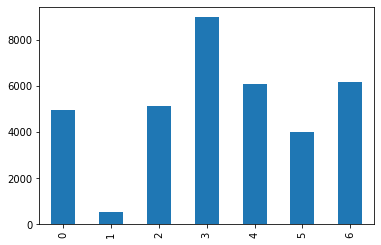

In [4]:
emotion = {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3,
           'Sad': 4, 'Surprise': 5, 'Neutral': 6}
emo     = ['Angry', 'Disgust', 'Fear', 'Happy',
           'Sad', 'Surprise', 'Neutral']

dis_emo = df['emotion'].value_counts(sort = False)
dis_emo.plot(kind = 'bar')

## Replace "Disgust" by "Angry"

Due to the number of "Disgust" images is very small compared with other classes. Therefore it can cause the imbalanced classes problem. In addition,  Angry face looks similar to Disgust faces. Thus, we replace "Disgust" label by "Angry" label. Finally, we solve the the facial expression recognition of six emotions: ['Angry', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [5]:
df['six_emotion'] = df['emotion'].apply(lambda x: 0 if x == 1 else x)

## Convert string pixels into numpy array

In [6]:
df['pixels'] = df['pixels'].apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))

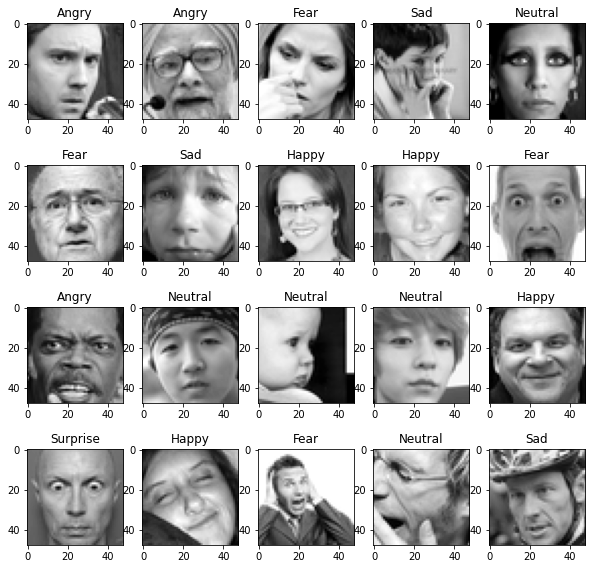

In [7]:
# show some images
showed_imgs = df['pixels'][0:20]
showed_label = df['six_emotion'][0:20]

fig=plt.figure(figsize=(10,10))
rows=4
colums=5
for i in range(20):
    img = showed_imgs[i]
    ax = plt.subplot(rows,colums,i+1)
    ax.imshow(img[:,:,0], cmap='gray')
    ax.set_title(emo[showed_label[i]])
plt.show() 

## Train Test Data

In [8]:
X_train = np.stack(df[df['Usage'] == "Training"]['pixels'], axis = 0)
y_train = np.stack(df[df['Usage'] == "Training"]['six_emotion'], axis = 0)

X_testPub = np.stack(df[df['Usage'] == "PublicTest"]['pixels'], axis = 0)
y_testPub = np.stack(df[df['Usage'] == "PublicTest"]['six_emotion'], axis = 0)

X_testPrivate = np.stack(df[df['Usage'] == "PrivateTest"]['pixels'], axis = 0)
y_testPrivate = np.stack(df[df['Usage'] == "PrivateTest"]['six_emotion'], axis = 0)

# categorical labels
le = LabelEncoder()
le.fit(df['six_emotion'])
y_train = to_categorical(le.transform(y_train))
y_testPub = to_categorical(le.transform(y_testPub))
y_testPrivate = to_categorical(le.transform(y_testPrivate))

# Normalize 
X_train = X_train/255.0
X_testPub = X_testPub/255.0
X_testPrivate = X_testPrivate/255.0

In [9]:
print("X_train: {}".format(X_train.shape))
print("X_testPub: {}".format(X_testPub.shape))
print("X_testPrivate: {}".format(X_testPrivate.shape))
print("y_train: {}".format(y_train.shape))
print("y_testPub: {}".format(y_testPub.shape))
print("y_testPrivate: {}".format(y_testPrivate.shape))


X_train: (28709, 48, 48, 1)
X_testPub: (3589, 48, 48, 1)
X_testPrivate: (3589, 48, 48, 1)
y_train: (28709, 6)
y_testPub: (3589, 6)
y_testPrivate: (3589, 6)


## Train Val Split

We will use public set as validation set and use private set to evaluate model

In [57]:
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, shuffle=True, stratify=y_train,
#                                                     test_size=0.2, random_state=1234)

## 2. Model Architecture

In [58]:
width = 48
height = 48
num_features = 64
num_labels = 6
        
model = Sequential()
model.add(Conv2D(num_features, kernel_size = (3, 3), activation = 'elu', input_shape = (width, height, 1), padding = "same", kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Conv2D(num_features, kernel_size =(3,3), activation = 'elu', padding = 'same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*num_features, kernel_size = (3, 3), activation = 'elu', padding = 'same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size = (3, 3), activation = 'elu', padding = 'same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(4*num_features, kernel_size = (3, 3), activation = 'elu', padding = 'same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Conv2D(4*num_features, kernel_size = (3, 3), activation = 'elu', padding = 'same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(2*num_features, activation = 'elu', kernel_initializer='he_normal'))
model.add(Dropout(0.4))
model.add(Dense(num_labels, activation = 'softmax'))

model.summary()
model.compile(loss = categorical_crossentropy,
             optimizer = Adam(lr = 0.001), metrics = ['accuracy'])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_42 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_43 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 24, 24, 128)      

In [59]:
batch_size = 32
epochs = 100

early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_accuracy', patience = 10)
checkpointer = ModelCheckpoint(filepath="/content/drive/My Drive/Facial_Expression_Recognition/models/model.h5", verbose=0, save_best_only=True)

history = model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs,
              verbose = 1, validation_data = (X_testPub, y_testPub), shuffle = True, callbacks = [early_stopping, checkpointer])

#saving the  model to be used later
model_json = model.to_json()
with open("/content/drive/My Drive/Facial_Expression_Recognition/models/model.json", "w") as json_file:
    json_file.write(model_json)
# model.save_weights("/content/drive/My Drive/Facial_Expression_Recognition/models/model.h5")

Epoch 1/100
898/898 [==============================] - 12s 13ms/step - loss: 2.0968 - accuracy: 0.2214 - val_loss: 1.6006 - val_accuracy: 0.3505
Epoch 2/100
898/898 [==============================] - 12s 13ms/step - loss: 1.7089 - accuracy: 0.2760 - val_loss: 1.4878 - val_accuracy: 0.4074
Epoch 3/100
898/898 [==============================] - 11s 13ms/step - loss: 1.5840 - accuracy: 0.3332 - val_loss: 1.4516 - val_accuracy: 0.4140
Epoch 4/100
898/898 [==============================] - 12s 13ms/step - loss: 1.4763 - accuracy: 0.3853 - val_loss: 1.3357 - val_accuracy: 0.4366
Epoch 5/100
898/898 [==============================] - 11s 13ms/step - loss: 1.4272 - accuracy: 0.4092 - val_loss: 1.2822 - val_accuracy: 0.4759
Epoch 6/100
898/898 [==============================] - 11s 13ms/step - loss: 1.3708 - accuracy: 0.4461 - val_loss: 1.2275 - val_accuracy: 0.5185
Epoch 7/100
898/898 [==============================] - 12s 14ms/step - loss: 1.3031 - accuracy: 0.4831 - val_loss: 1.1945 - val_ac

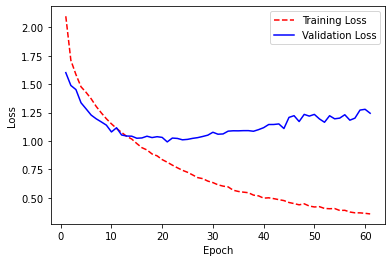

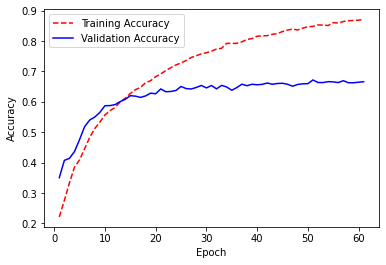

In [60]:

epoch_count = range(1, len(history.history['loss']) + 1)

plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(epoch_count, history.history['accuracy'], 'r--')
plt.plot(epoch_count, history.history['val_accuracy'], 'b-')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

## 3. Evaluation

In [61]:
with open ("/content/drive/My Drive/Facial_Expression_Recognition/models/model.json", "r") as json_file:
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights("/content/drive/My Drive/Facial_Expression_Recognition/models/model.h5")



# # test on Public-test dataset
# print('Test performance in Public set')
# y_pre = loaded_model.predict(X_testPub)
# print(classification_report( np.argmax(y_pre, axis = 1) , np.argmax(y_testPub, axis = 1)))
# print(accuracy_score( np.argmax(y_pre, axis = 1) , np.argmax(y_testPub, axis = 1)))

# test on Private-test dataset
print('Test performance in Private set')
y_pre = loaded_model.predict(X_testPrivate)

print(classification_report( np.argmax(y_pre, axis = 1) , np.argmax(y_testPrivate, axis = 1)))
print(accuracy_score( np.argmax(y_pre, axis = 1) , np.argmax(y_testPrivate, axis = 1) ))

Test performance in Private set
              precision    recall  f1-score   support

           0       0.59      0.65      0.62       493
           1       0.39      0.51      0.44       402
           2       0.83      0.89      0.86       818
           3       0.55      0.48      0.51       682
           4       0.73      0.79      0.76       383
           5       0.72      0.55      0.62       811

    accuracy                           0.65      3589
   macro avg       0.63      0.65      0.64      3589
weighted avg       0.66      0.65      0.65      3589

0.6505990526609083


# Data augmentation

We realize that our dataset is quit small, therefore we try to use ImageDataGenerator to generate more data. This can increase the performance of model. We wil examine it by camparing with the previous model.

- rotation_range is a value in degrees (0-180), a range within which to randomly rotate pictures
- width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
- shear_range is for randomly applying shearing transformations
- zoom_range is for randomly zooming inside pictures
- horizontal_flip is for randomly flipping half of the images horizontally --relevant when there are no assumptions of horizontal assymetry (e.g. real-world pictures).
- fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.



In [62]:
datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest')

sample_img = X_train[0].reshape(1,48,48,1)
datagen.fit(sample_img)
num_batches = 19
generated_sample = sample_img

for images in datagen.flow(sample_img, batch_size = 1):
    if (num_batches == 0):
        break
    generated_sample = np.append(generated_sample, images, axis=0)
    num_batches = num_batches - 1

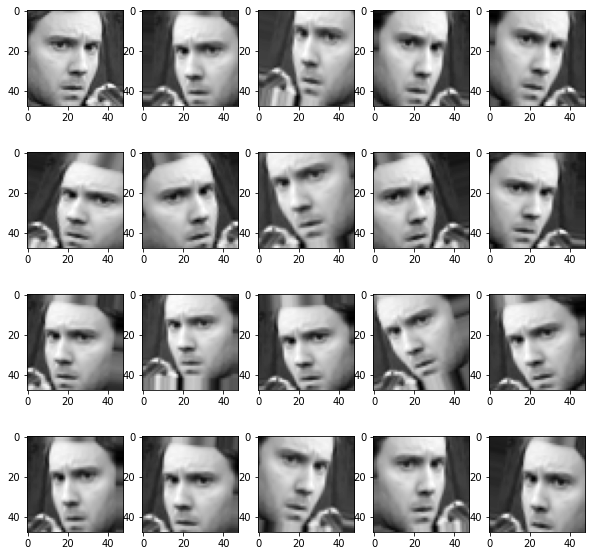

In [63]:
# show some images
showed_imgs = generated_sample

fig=plt.figure(figsize=(10,10))
rows=4
colums=5
for i in range(20):
    img = showed_imgs[i]
    ax = plt.subplot(rows,colums,i+1)
    ax.imshow(img[:,:,0], cmap='gray')
plt.show() 

In [64]:
datagen.fit(X_train)
num_batches = 2
generatedX_train = X_train
generatedy_train = y_train

for images, label in datagen.flow(X_train, y_train, batch_size = len(X_train)):
    if (num_batches == 0):
        break
    generatedX_train = np.append(generatedX_train, images, axis=0)
    generatedy_train = np.append(generatedy_train, label, axis=0)
    num_batches = num_batches - 1

In [65]:
print(generatedX_train.shape)

(86127, 48, 48, 1)


In [66]:
print(generatedy_train.sum(axis=0))

[13293. 12291. 21645. 14490.  9513. 14895.]


In [67]:
width = 48
height = 48
num_features = 64
num_labels = 6
        
model = Sequential()
model.add(Conv2D(num_features, kernel_size = (3, 3), activation = 'elu', input_shape = (width, height, 1), padding = "same", kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Conv2D(num_features, kernel_size =(3,3), activation = 'elu', padding = 'same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*num_features, kernel_size = (3, 3), activation = 'elu', padding = 'same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size = (3, 3), activation = 'elu', padding = 'same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(4*num_features, kernel_size = (3, 3), activation = 'elu', padding = 'same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Conv2D(4*num_features, kernel_size = (3, 3), activation = 'elu', padding = 'same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(2*num_features, activation = 'elu', kernel_initializer='he_normal'))
model.add(Dropout(0.4))
model.add(Dense(num_labels, activation = 'softmax'))

model.summary()
model.compile(loss = categorical_crossentropy,
             optimizer = Adam(lr = 0.001), metrics = ['accuracy'])

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_48 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_49 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 24, 24, 128)      

In [68]:
batch_size = 32
epochs = 100

early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_accuracy', patience = 10)
checkpointer = ModelCheckpoint(filepath="/content/drive/My Drive/Facial_Expression_Recognition/models/model_aug.h5", verbose=0, save_best_only=True)

history = model.fit(generatedX_train, generatedy_train, batch_size = batch_size, epochs = epochs,
              verbose = 1, validation_data = (X_testPub, y_testPub), shuffle = True, callbacks = [early_stopping, checkpointer])

#saving the  model to be used later
model_json = model.to_json()
with open("/content/drive/My Drive/Facial_Expression_Recognition/models/model_aug.json", "w") as json_file:
    json_file.write(model_json)
# model.save_weights("/content/drive/My Drive/Facial_Expression_Recognition/models/model.h5")

Epoch 1/100
2692/2692 [==============================] - 33s 12ms/step - loss: 1.9033 - accuracy: 0.2121 - val_loss: 1.7650 - val_accuracy: 0.2494
Epoch 2/100
2692/2692 [==============================] - 33s 12ms/step - loss: 1.7771 - accuracy: 0.2378 - val_loss: 1.7752 - val_accuracy: 0.2513
Epoch 3/100
2692/2692 [==============================] - 33s 12ms/step - loss: 1.7759 - accuracy: 0.2382 - val_loss: 1.7783 - val_accuracy: 0.2494
Epoch 4/100
2692/2692 [==============================] - 34s 13ms/step - loss: 1.7639 - accuracy: 0.2472 - val_loss: 1.6353 - val_accuracy: 0.3238
Epoch 5/100
2692/2692 [==============================] - 33s 12ms/step - loss: 1.6606 - accuracy: 0.3004 - val_loss: 1.4356 - val_accuracy: 0.4146
Epoch 6/100
2692/2692 [==============================] - 33s 12ms/step - loss: 1.4965 - accuracy: 0.3802 - val_loss: 1.2669 - val_accuracy: 0.4879
Epoch 7/100
2692/2692 [==============================] - 33s 12ms/step - loss: 1.3630 - accuracy: 0.4523 - val_loss: 1

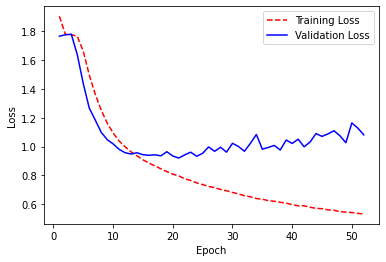

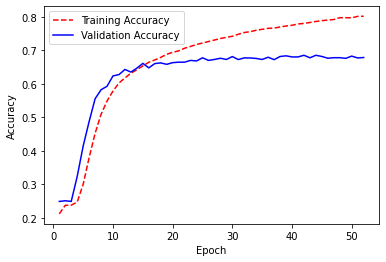

In [69]:

epoch_count = range(1, len(history.history['loss']) + 1)

plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(epoch_count, history.history['accuracy'], 'r--')
plt.plot(epoch_count, history.history['val_accuracy'], 'b-')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [70]:
with open ("/content/drive/My Drive/Facial_Expression_Recognition/models/model_aug.json", "r") as json_file:
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights("/content/drive/My Drive/Facial_Expression_Recognition/models/model_aug.h5")



# # test on Public-test dataset
# print('Test performance in Public set')
# y_pre = loaded_model.predict(X_testPub)
# print(classification_report( np.argmax(y_pre, axis = 1) , np.argmax(y_testPub, axis = 1)))
# print(accuracy_score( np.argmax(y_pre, axis = 1) , np.argmax(y_testPub, axis = 1)))

# test on Private-test dataset
print('Test performance in Private set')
y_pre = loaded_model.predict(X_testPrivate)

print(classification_report( np.argmax(y_pre, axis = 1) , np.argmax(y_testPrivate, axis = 1)))
print(accuracy_score( np.argmax(y_pre, axis = 1) , np.argmax(y_testPrivate, axis = 1) ))

Test performance in Private set
              precision    recall  f1-score   support

           0       0.70      0.59      0.64       647
           1       0.37      0.61      0.46       324
           2       0.89      0.88      0.89       883
           3       0.57      0.54      0.56       624
           4       0.74      0.77      0.75       401
           5       0.70      0.62      0.66       710

    accuracy                           0.68      3589
   macro avg       0.66      0.67      0.66      3589
weighted avg       0.70      0.68      0.69      3589

0.6815268877124547


compared with the performance of the model trained with original dataset, data augmentation increases the accuracy by 3%

# Part 2: Application

We build an application by intergrating the trained model with webcam. However, instead of building a six-emotions classifier, we build a three-classes classifier (happy, natural, sad) to get a higher accuracy that will be useful for an application.

In [10]:
df3 = df[df['emotion'].apply(lambda x: x in [3,4,6])]

In [11]:
df3.head()

,emotion,pixels,Usage,six_emotion
3,4,"[[[24.0], [32.0], [36.0], [30.0], [32.0], [23....",Training,4
4,6,"[[[4.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",Training,6
6,4,"[[[20.0], [17.0], [19.0], [21.0], [25.0], [38....",Training,4
7,3,"[[[77.0], [78.0], [79.0], [79.0], [78.0], [75....",Training,3
8,3,"[[[85.0], [84.0], [90.0], [121.0], [101.0], [1...",Training,3


In [12]:
df3['emotion'].value_counts()

3    8989
6    6198
4    6077
Name: emotion, dtype: int64

In [13]:
X_train = np.stack(df3[df3['Usage'] == "Training"]['pixels'], axis = 0)
y_train = np.stack(df3[df3['Usage'] == "Training"]['emotion'], axis = 0)

X_testPub = np.stack(df3[df3['Usage'] == "PublicTest"]['pixels'], axis = 0)
y_testPub = np.stack(df3[df3['Usage'] == "PublicTest"]['emotion'], axis = 0)

X_testPrivate = np.stack(df3[df3['Usage'] == "PrivateTest"]['pixels'], axis = 0)
y_testPrivate = np.stack(df3[df3['Usage'] == "PrivateTest"]['emotion'], axis = 0)

# categorical labels
le = LabelEncoder()
le.fit(df3['emotion'])
y_train = to_categorical(le.transform(y_train))
y_testPub = to_categorical(le.transform(y_testPub))
y_testPrivate = to_categorical(le.transform(y_testPrivate))

# Normalize 
X_train = X_train/255.0
X_testPub = X_testPub/255.0
X_testPrivate = X_testPrivate/255.0

In [14]:
print("X_train: {}".format(X_train.shape))
print("X_testPub: {}".format(X_testPub.shape))
print("X_testPrivate: {}".format(X_testPrivate.shape))
print("y_train: {}".format(y_train.shape))
print("y_testPub: {}".format(y_testPub.shape))
print("y_testPrivate: {}".format(y_testPrivate.shape))


X_train: (17010, 48, 48, 1)
X_testPub: (2155, 48, 48, 1)
X_testPrivate: (2099, 48, 48, 1)
y_train: (17010, 3)
y_testPub: (2155, 3)
y_testPrivate: (2099, 3)


In [15]:
# data augmentation
datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest')

datagen.fit(X_train)
num_batches = 2
generatedX_train = X_train
generatedy_train = y_train

for images, label in datagen.flow(X_train, y_train, batch_size = len(X_train)):
    if (num_batches == 0):
        break
    generatedX_train = np.append(generatedX_train, images, axis=0)
    generatedy_train = np.append(generatedy_train, label, axis=0)
    num_batches = num_batches - 1

In [24]:
print(generatedX_train.shape)
print(generatedy_train.shape)

(51030, 48, 48, 1)
(51030, 3)


In [30]:
width = 48
height = 48
num_features = 64
num_labels = 3
        
model = Sequential()
model.add(Conv2D(num_features, kernel_size = (3, 3), activation = 'elu', input_shape = (width, height, 1), padding = "same", kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Conv2D(num_features, kernel_size =(3, 3), activation = 'elu', padding = 'same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(2*num_features, kernel_size = (3, 3), activation = 'elu', padding = 'same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size = (3, 3), activation = 'relu', padding = 'same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(4*num_features, kernel_size = (3, 3), activation = 'elu', padding = 'same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Conv2D(4*num_features, kernel_size = (3, 3), activation = 'elu', padding = 'same', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(2*num_features, activation = 'elu', kernel_initializer='he_normal'))
model.add(Dropout(0.5))
model.add(Dense(num_labels, activation = 'softmax'))

model.summary()
model.compile(loss = categorical_crossentropy,
             optimizer = Adam(lr = 0.001), metrics = ['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_18 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_19 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 24, 24, 128)      

In [31]:
batch_size = 32
epochs = 100

acc_early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_accuracy', patience = 10)
loss_early_stopping = EarlyStopping(min_delta = 0.001, mode = 'min', monitor='val_loss', patience = 10)
checkpointer = ModelCheckpoint(filepath="/content/drive/My Drive/Facial_Expression_Recognition/models/model_3class.h5", verbose=0, save_best_only=True)

history = model.fit(generatedX_train, generatedy_train, batch_size = batch_size, epochs = epochs,
              verbose = 1, validation_data = (X_testPub, y_testPub), shuffle = True, callbacks = [acc_early_stopping, loss_early_stopping, checkpointer])

#saving the  model to be used later
model_json = model.to_json()
with open("/content/drive/My Drive/Facial_Expression_Recognition/models/model_3class.json", "w") as json_file:
    json_file.write(model_json)
# model.save_weights("/content/drive/My Drive/Facial_Expression_Recognition/models/model.h5")

Epoch 1/100
1595/1595 [==============================] - 68s 43ms/step - loss: 1.1328 - accuracy: 0.4702 - val_loss: 0.7535 - val_accuracy: 0.6520
Epoch 2/100
1595/1595 [==============================] - 68s 42ms/step - loss: 0.8030 - accuracy: 0.6112 - val_loss: 0.6954 - val_accuracy: 0.6497
Epoch 3/100
1595/1595 [==============================] - 68s 42ms/step - loss: 0.7253 - accuracy: 0.6599 - val_loss: 0.6643 - val_accuracy: 0.7030
Epoch 4/100
1595/1595 [==============================] - 67s 42ms/step - loss: 0.6655 - accuracy: 0.7048 - val_loss: 0.6297 - val_accuracy: 0.7267
Epoch 5/100
1595/1595 [==============================] - 67s 42ms/step - loss: 0.6222 - accuracy: 0.7284 - val_loss: 0.6070 - val_accuracy: 0.7202
Epoch 6/100
1595/1595 [==============================] - 67s 42ms/step - loss: 0.5761 - accuracy: 0.7527 - val_loss: 0.5859 - val_accuracy: 0.7490
Epoch 7/100
1595/1595 [==============================] - 67s 42ms/step - loss: 0.5467 - accuracy: 0.7660 - val_loss: 0

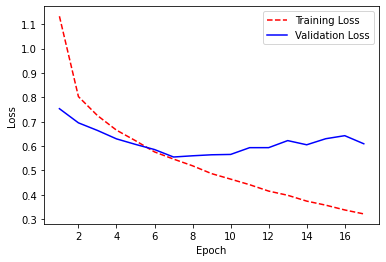

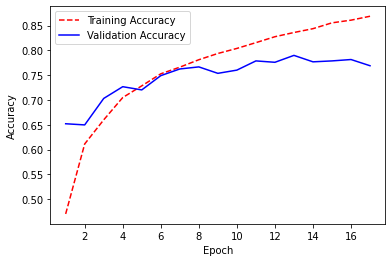

In [32]:

epoch_count = range(1, len(history.history['loss']) + 1)

plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(epoch_count, history.history['accuracy'], 'r--')
plt.plot(epoch_count, history.history['val_accuracy'], 'b-')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [33]:
with open ("/content/drive/My Drive/Facial_Expression_Recognition/models/model_3class.json", "r") as json_file:
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights("/content/drive/My Drive/Facial_Expression_Recognition/models/model_3class.h5")



# # test on Public-test dataset
# print('Test performance in Public set')
# y_pre = loaded_model.predict(X_testPub)
# print(classification_report( np.argmax(y_pre, axis = 1) , np.argmax(y_testPub, axis = 1)))
# print(accuracy_score( np.argmax(y_pre, axis = 1) , np.argmax(y_testPub, axis = 1)))

# test on Private-test dataset
print('Test performance in Private set')
y_pre = loaded_model.predict(X_testPrivate)

print(classification_report( np.argmax(y_pre, axis = 1) , np.argmax(y_testPrivate, axis = 1)))
print(accuracy_score( np.argmax(y_pre, axis = 1) , np.argmax(y_testPrivate, axis = 1) ))

Test performance in Private set
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       890
           1       0.58      0.73      0.65       467
           2       0.80      0.67      0.73       742

    accuracy                           0.78      2099
   macro avg       0.76      0.77      0.76      2099
weighted avg       0.79      0.78      0.78      2099

0.7798951881848499
